In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
from domino.core import PatternFilter
from domino.core import LaggedAnalyser
from domino.core import IndexGenerator

def full_C_is_positive(ds_dummy,full_ds):
    return full_ds>0
def anom_C_geq_thresh(ds,thr):
    return ds>thr
import matplotlib.pyplot as plt

In [2]:
hurricanes=xr.open_dataarray('/data/ox5324/compute_2021_clean_data/6h_Atl_hurricanes.nc').load()

In [3]:
hurricane_count=hurricanes.sum(('lat','lon'))

In [22]:
regions=['W_France','South_Italy','North_Italy','W_Iberia','Adriatic_coast','C_France','InBI','E_Eng','Lo_Countries']

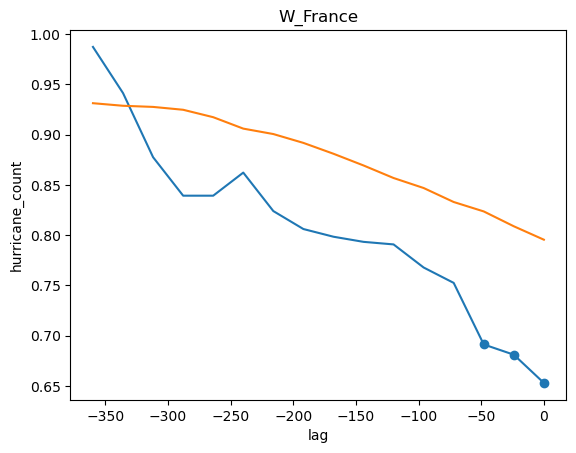

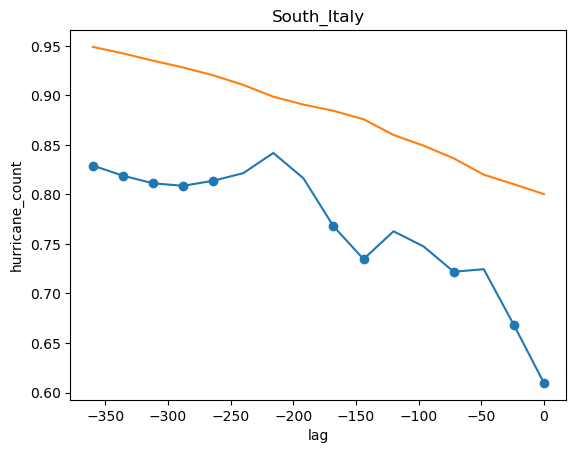

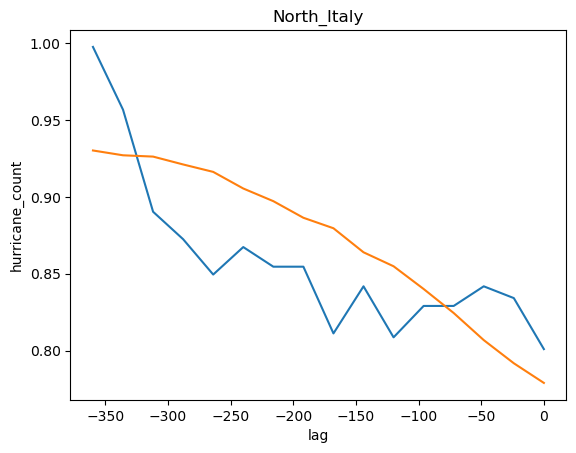

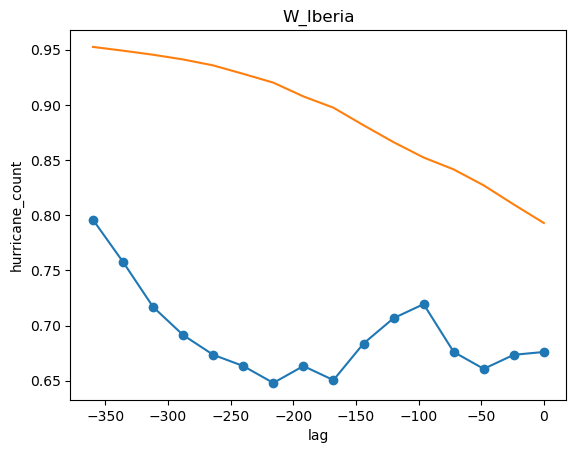

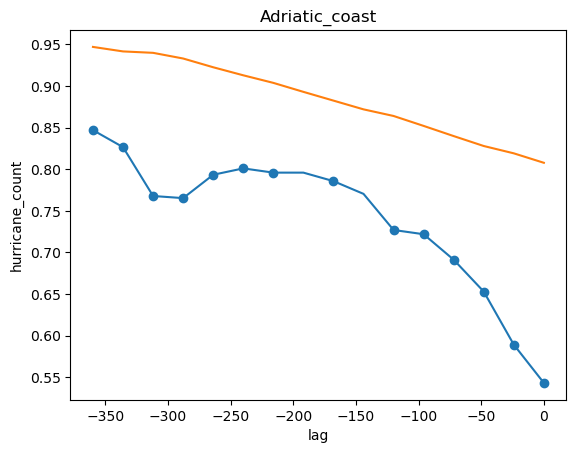

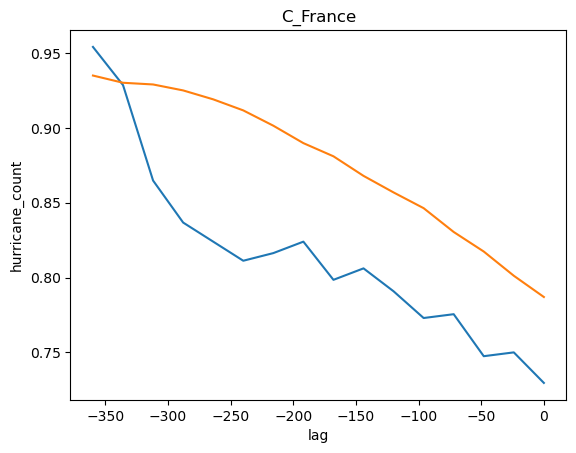

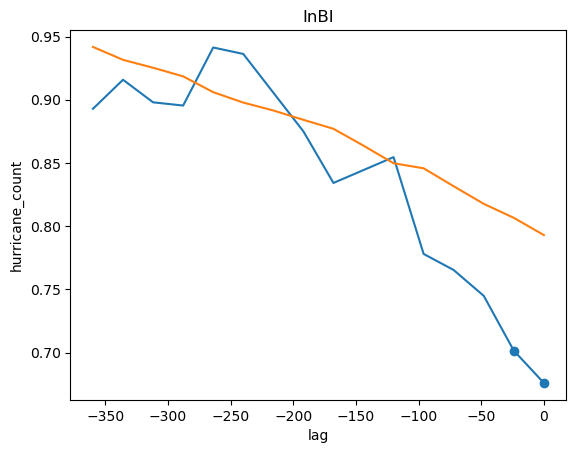

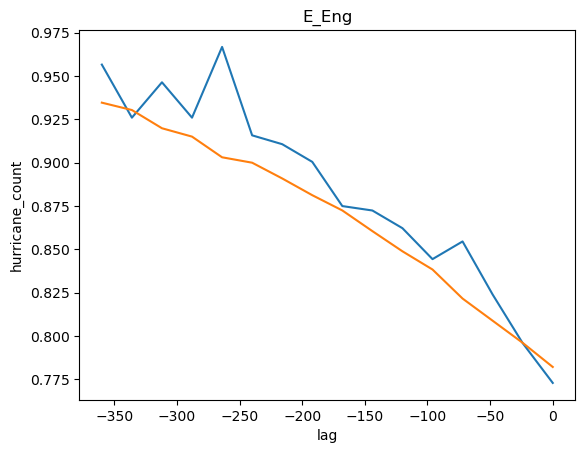

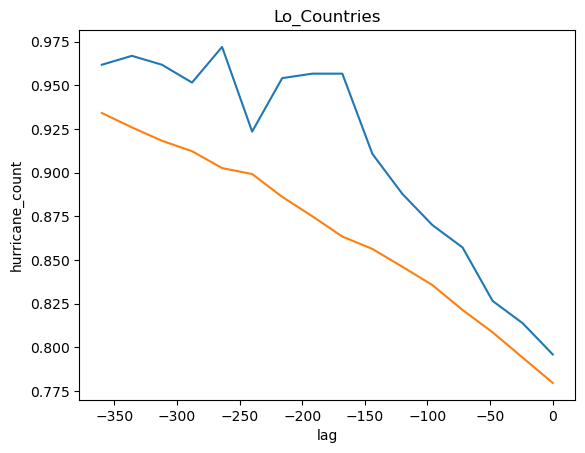

In [25]:
for region in regions:
    events=xr.open_dataarray(f'/data/ox5324/precursor_computation/event_indices/{region}_SON_ERA5_p90_daily_rainfall.nc')

    count_analyser=LaggedAnalyser(event=events,variables=hurricane_count,name='hurricane_count')
    count_analyser.lag_variables(range(-360,1,24),offset_unit='hours')
    n=count_analyser.compute_composites(as_anomaly=False)
    s=count_analyser.bootstrap_significance(1000,0.05,synth_mode='shuffle')
    fig,ax=plt.subplots(1)
    n.sel(index_val=1).hurricane_count.plot(marker='o',markevery=s.sel(index_val=1).hurricane_count.values==1)
    n.sel(index_val=0).hurricane_count.plot()
    ax.set_title(region)

In [28]:
regions2=['S_scandi','E_DE_Pl','N_C_Europe','Danube','CZ']

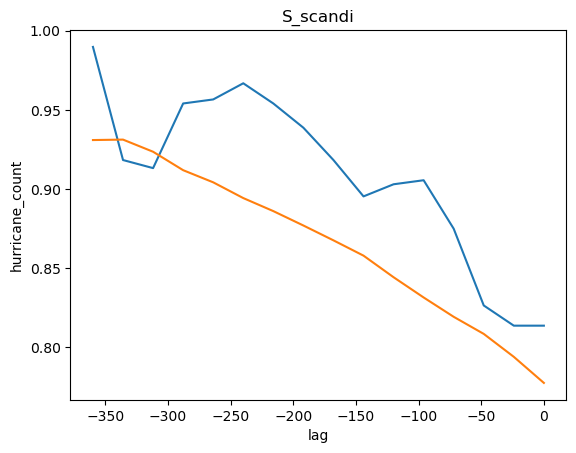

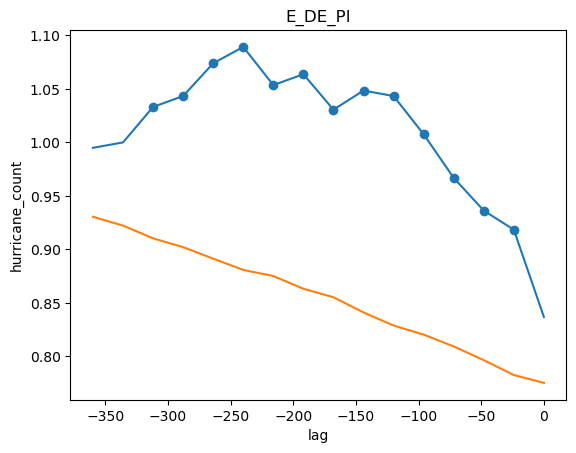

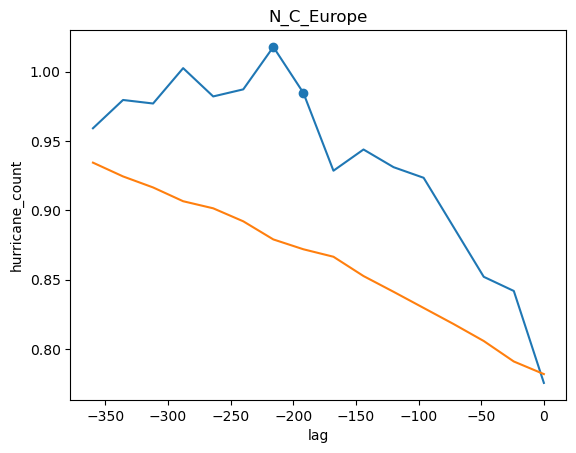

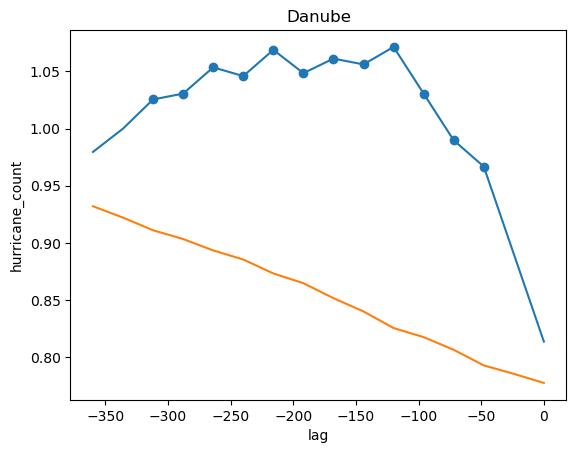

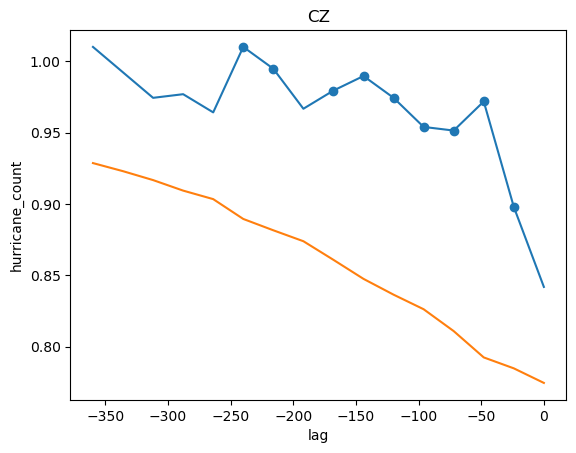

In [29]:
for region in regions2:
    events=xr.open_dataarray(f'/data/ox5324/precursor_computation/event_indices/{region}_SON_ERA5_p90_daily_rainfall.nc')

    count_analyser=LaggedAnalyser(event=events,variables=hurricane_count,name='hurricane_count')
    count_analyser.lag_variables(range(-360,1,24),offset_unit='hours')
    n=count_analyser.compute_composites(as_anomaly=False)
    s=count_analyser.bootstrap_significance(1000,0.05,synth_mode='shuffle')
    fig,ax=plt.subplots(1)
    n.sel(index_val=1).hurricane_count.plot(marker='o',markevery=s.sel(index_val=1).hurricane_count.values==1)
    n.sel(index_val=0).hurricane_count.plot()
    ax.set_title(region)

In [240]:
PF=PatternFilter(mask_ds=hurricanes.to_dataset(name='hurricane'))
PF.apply_convolution(11,('lat','lon'))
hurricanes_10deg=PF.get_mask().hurricane

In [241]:
region='E_DE_Pl'
events=xr.open_dataarray(f'/data/ox5324/precursor_computation/event_indices/{region}_SON_ERA5_p90_daily_rainfall.nc')

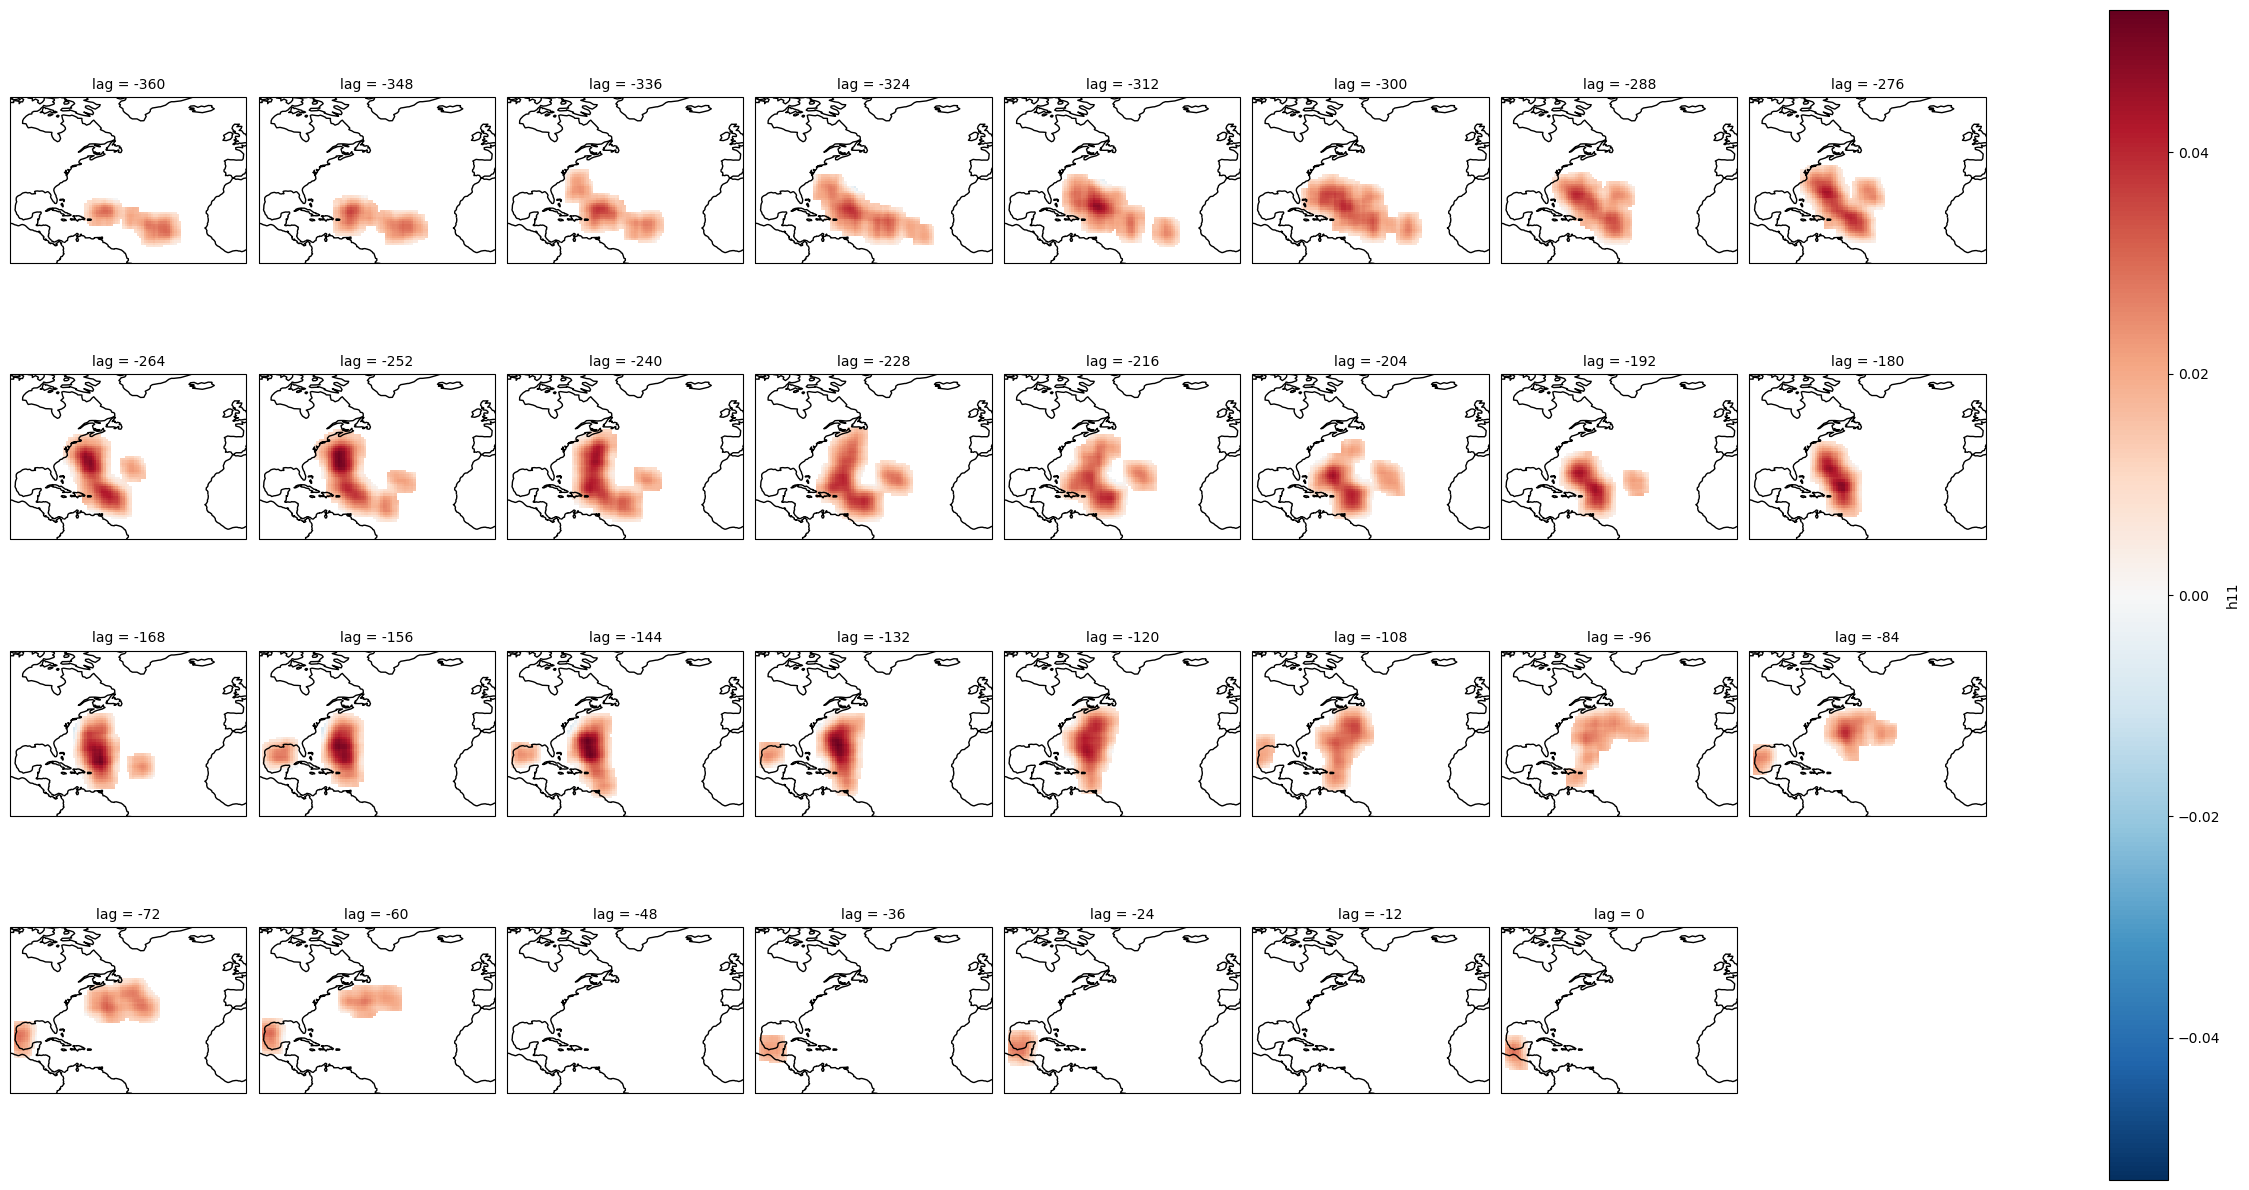

In [242]:
analyser=LaggedAnalyser(event=events,variables=dict(h11=hurricanes_10deg))
analyser.lag_variables(np.arange(-360,1,12),offset_unit='hours')
C=analyser.compute_composites(as_anomaly=True)
Cfull=analyser.compute_composites(as_anomaly=False)
S=analyser.bootstrap_significance(400,p=0.05,reuse_lag0_boots=False,synth_mode='shuffle')
Csmooth=C.rolling(lat=5,center=True).mean().rolling(lon=5,center=True).mean()
maskfilter=PatternFilter(val_ds=Csmooth,mask_ds=S)
maskfilter.apply_value_mask(anom_C_geq_thresh,0.02)
maskfilter.apply_convolution(7,('lat','lon'))
maskfilter.apply_area_mask(100,dims=('lat','lon'),area_type='spherical')
M=maskfilter.get_mask()
CM=Csmooth.where(M==1)
p=CM.h11.sel(index_val=1).plot(col='lag',col_wrap=8,transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.PlateCarree()))
for a in p.axes.flat:
    a.coastlines()
    a.set_extent([-100,0,0,70],crs=ccrs.PlateCarree())

In [243]:
slices=[dict(index_val=1,lag=l) for l in np.arange(-360,1,24)]
SON_hurricanes=hurricanes[hurricanes['time.season']=='SON'].to_dataset(name='h11')
IG=IndexGenerator()
indices=IG.generate(CM,SON_hurricanes,slices=slices)
index_analyser=LaggedAnalyser(event=events,variables=indices)
index_analyser.lag_variables(np.arange(-20,1))
Cfull=index_analyser.compute_composites(as_anomaly=False)
Canom=index_analyser.compute_composites(as_anomaly=True)

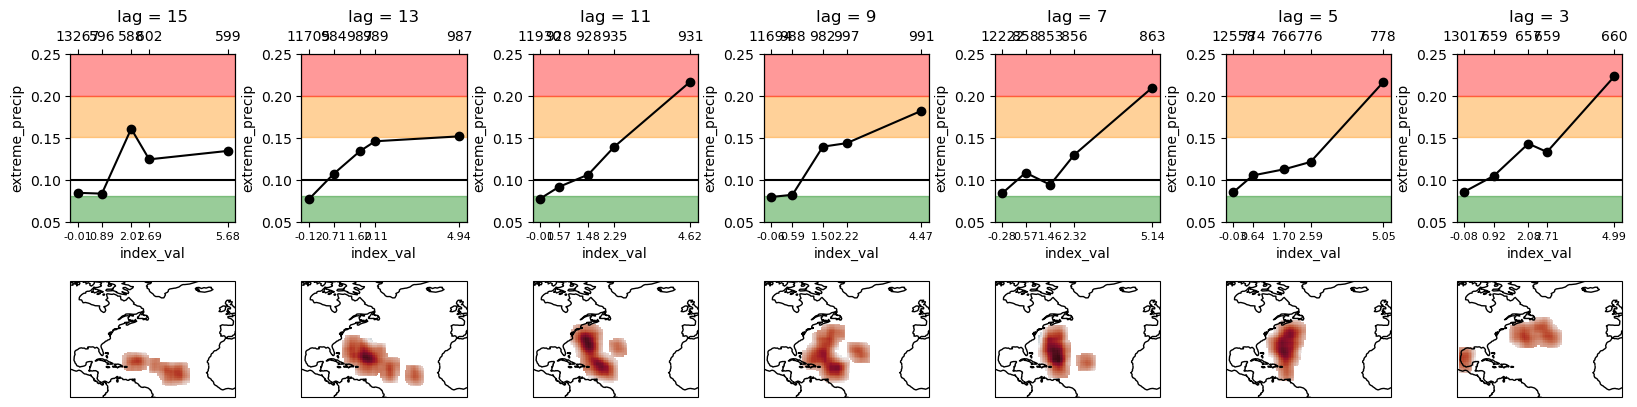

In [324]:
fig=plt.figure()
lags=np.arange(-360,1,48)
for n in range(7):
    a1=fig.add_subplot(2,8,n+1)
    a3=fig.add_subplot(2,8,n+9,projection=ccrs.PlateCarree())
    
    l=lags[n]
    ix=indices[f'h11_index_val1_lag{l}']
    #we make the index nonstandardised:
    a,b=np.unique(ix,return_counts=True)
    mode=a[np.argmax(b)]
    ix=ix-mode

    #We convert to a categorical index
    bin_boundaries=np.array([ix.min(),*ix[ix>0].quantile(np.arange(0.0,1.01,0.25)).values])
    index_categories=np.digitize(ix,bin_boundaries)
    index_categories[index_categories==index_categories.max()]=index_categories.max()-1
    index_categories=xr.DataArray(data=index_categories,coords=dict(time=ix.time))
    ixfocus_analyser=LaggedAnalyser(event=index_categories,variables=events,name='extreme_precip')
    ixfocus_analyser.lag_variables(np.arange(0,21))
    event_C=ixfocus_analyser.compute_composites(as_anomaly=False)

    bin_labels=[f'{bi:.2f}-{bf:.2f}' for bi,bf in zip(bin_boundaries[:-1],bin_boundaries[1:])]
    bin_centres=[(bi+bf)/2 for bi,bf in zip(bin_boundaries[:-1],bin_boundaries[1:])]
    event_C=event_C.assign_coords(coords={'index_val':bin_centres})
    event_C.sel(lag=-l/24).extreme_precip.plot(marker='o',ax=a1,color='k')
    a1.set_xticks(bin_centres,fontsize=8)
    a1.set_xticklabels([f'{b:.2f}' for b in bin_centres],fontsize=8)

    a1.set_ylim(0.05,0.25)
    xlim=a1.get_xlim()
    a1.hlines(0.1,*xlim,colors='k')
    a2=a1.twiny()
    n=np.unique(index_categories,return_counts=True)[1]
    a2.set_xticks(bin_centres,fontsize=8)
    a2.set_xticklabels(n)
    a1.set_xlim(xlim)
    a2.set_xlim(xlim)
    
    a1.fill_between(xlim,0.05,0.08,color='green',alpha=0.4)
    a1.fill_between(xlim,0.151,0.2,color='darkorange',alpha=0.4)
    a1.fill_between(xlim,0.2,0.25,color='red',alpha=0.4)

    p=CM.h11.sel(index_val=1,lag=l).plot(ax=a3,transform=ccrs.PlateCarree(),vmin=-0.05,vmax=0.05,cmap=cm.balance,add_colorbar=False)
    a3.coastlines()
    a3.set_title('')
    a3.set_extent([-100,0,0,70],crs=ccrs.PlateCarree())
fig.set_figwidth(23)
fig.subplots_adjust(wspace=0.4)



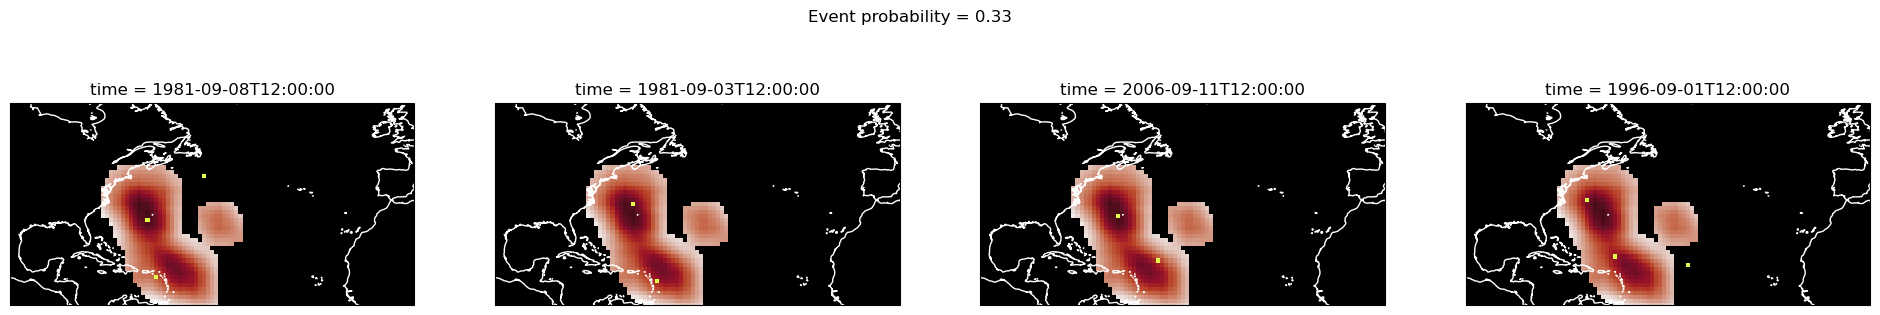

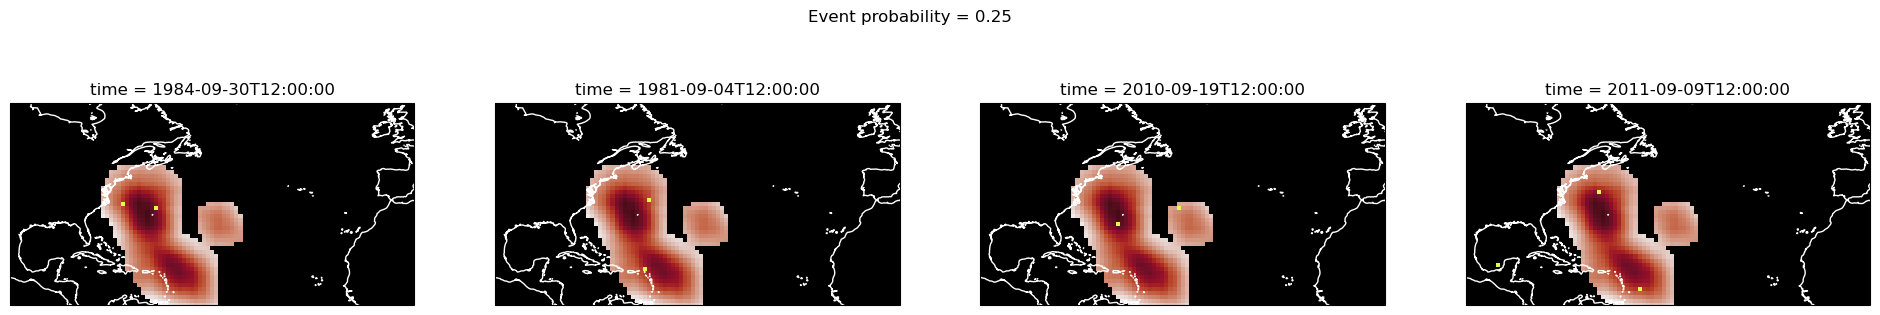

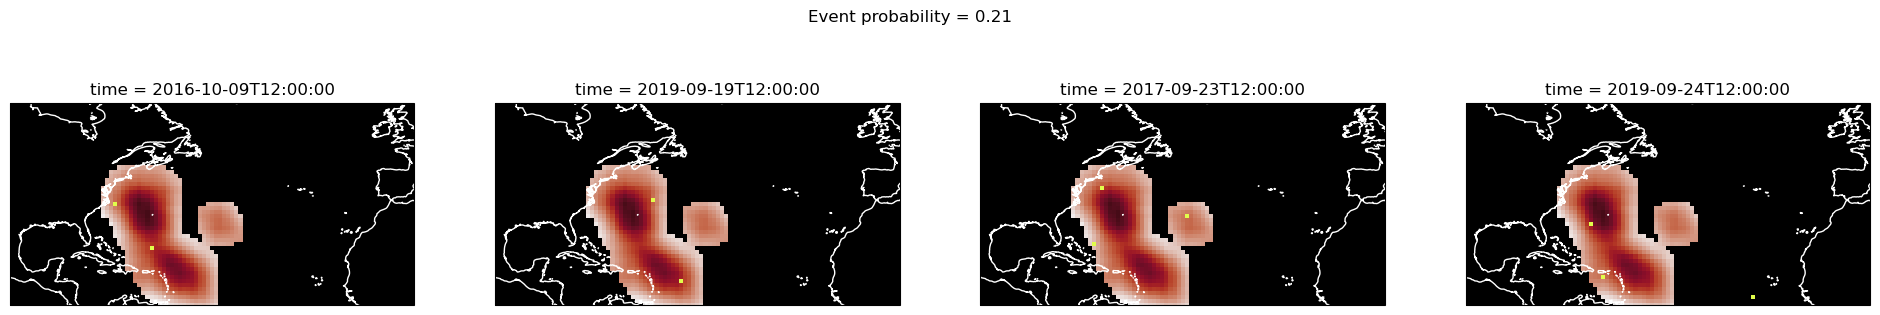

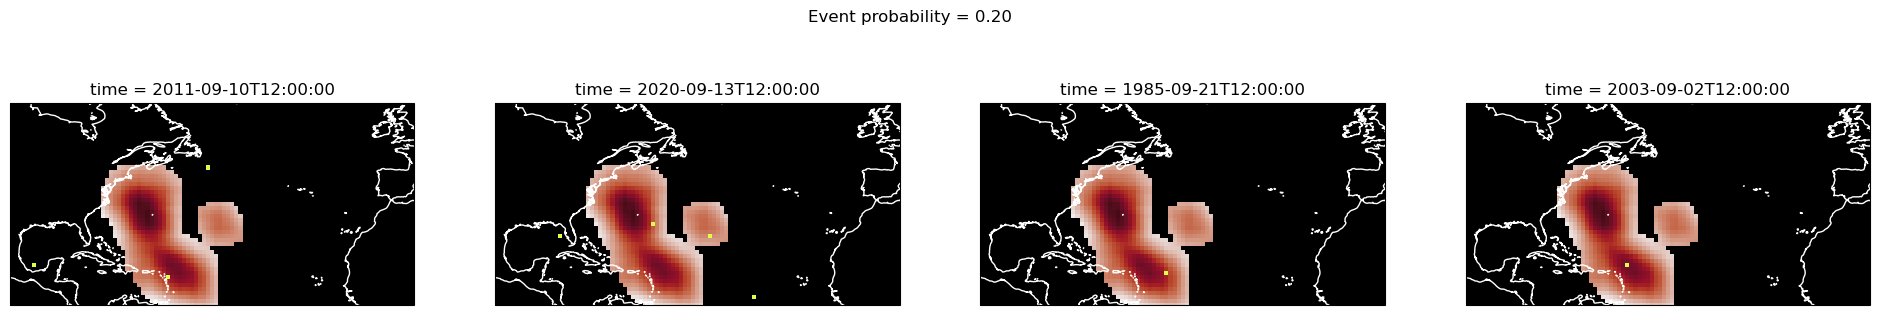

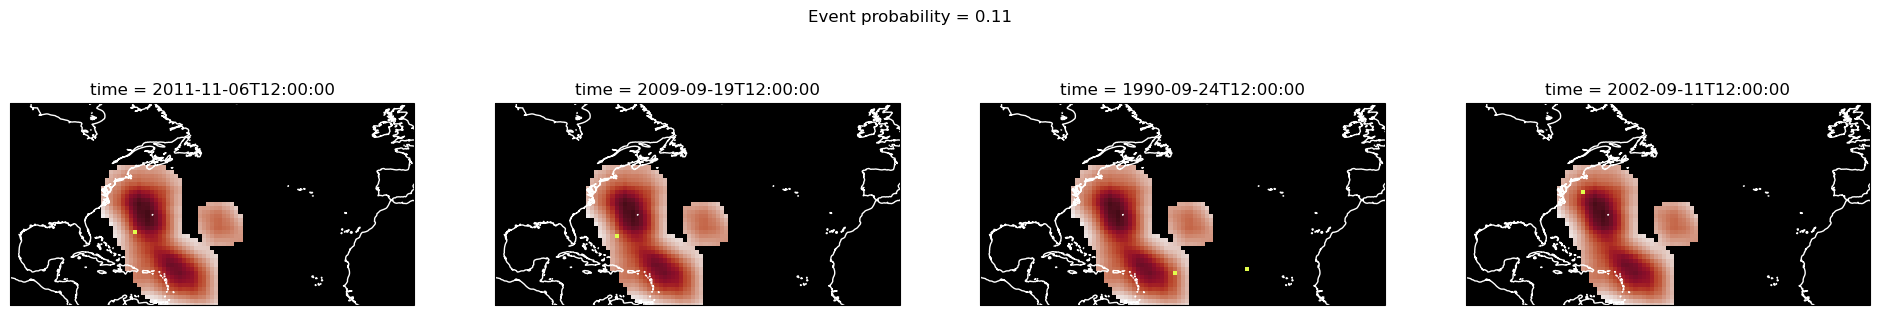

In [323]:
import datetime as dt
import pandas as pd
ixover5=indices['h11_index_val1_lag-264']>5
ixover4=(indices['h11_index_val1_lag-264']>4)*(indices['h11_index_val1_lag-264']<5)
ixover3=(indices['h11_index_val1_lag-264']>3)*(indices['h11_index_val1_lag-264']<4)
ixover2=(indices['h11_index_val1_lag-264']>2)*(indices['h11_index_val1_lag-264']<3)
ixover1=(indices['h11_index_val1_lag-264']>1)*(indices['h11_index_val1_lag-264']<2)
for ixover in [ixover5,ixover4,ixover3,ixover2,ixover1]:
    ts=ixover[ixover==1].time
    e=events.sel(time=[pd.Timestamp(t)+dt.timedelta(days=11) for t in ts.values if pd.Timestamp(t)+dt.timedelta(days=11) in events.time])
    h=hurricanes.sel(time=[pd.Timestamp(t) for t in ts.values if t in events.time])
    fig,ax=plt.subplots(1,4,subplot_kw=dict(projection=ccrs.PlateCarree()))
    l=len(h.time)
    h=h.isel(time=np.random.choice(l,4,replace=False))
    for i in range(4):
        ax[i].set_facecolor('k')
        p=CM.h11.sel(index_val=1,lag=-264).plot(ax=ax[i],transform=ccrs.PlateCarree(),vmin=-0.05,vmax=0.05,cmap=cm.balance,add_colorbar=False)
        h.where(h==1).isel(time=i).plot(ax=ax[i],transform=ccrs.PlateCarree(),add_colorbar=False,cmap=cm.solar,vmin=-2,vmax=1)
        ax[i].coastlines(color='w')
        ax[i].set_extent([-100,0,10,60],crs=ccrs.PlateCarree())
    fig.set_figwidth(24)
    fig.set_figheight(4)
    fig.suptitle(f'Event probability = {e.mean().values:.2f}')


In [ ]:
ixover5

<xarray.DataArray 'E_DE_Pl' (time: 9)>
array([0, 0, 0, 0, 0, 1, 0, 0, 1])
Coordinates:
  * time      (time) datetime64[ns] 1981-09-03T12:00:00 ... 2019-09-25T12:00:00
    quantile  float64 0.9
    season    <U3 'SON'
    region    <U7 'E_DE_Pl'

In [264]:
[t for t in ts if t in events.time]

ValueError: dimensions () must have the same length as the number of data dimensions, ndim=1

In [235]:
region='Danube'
events=xr.open_dataarray(f'/data/ox5324/precursor_computation/event_indices/{region}_SON_ERA5_p90_daily_rainfall.nc')

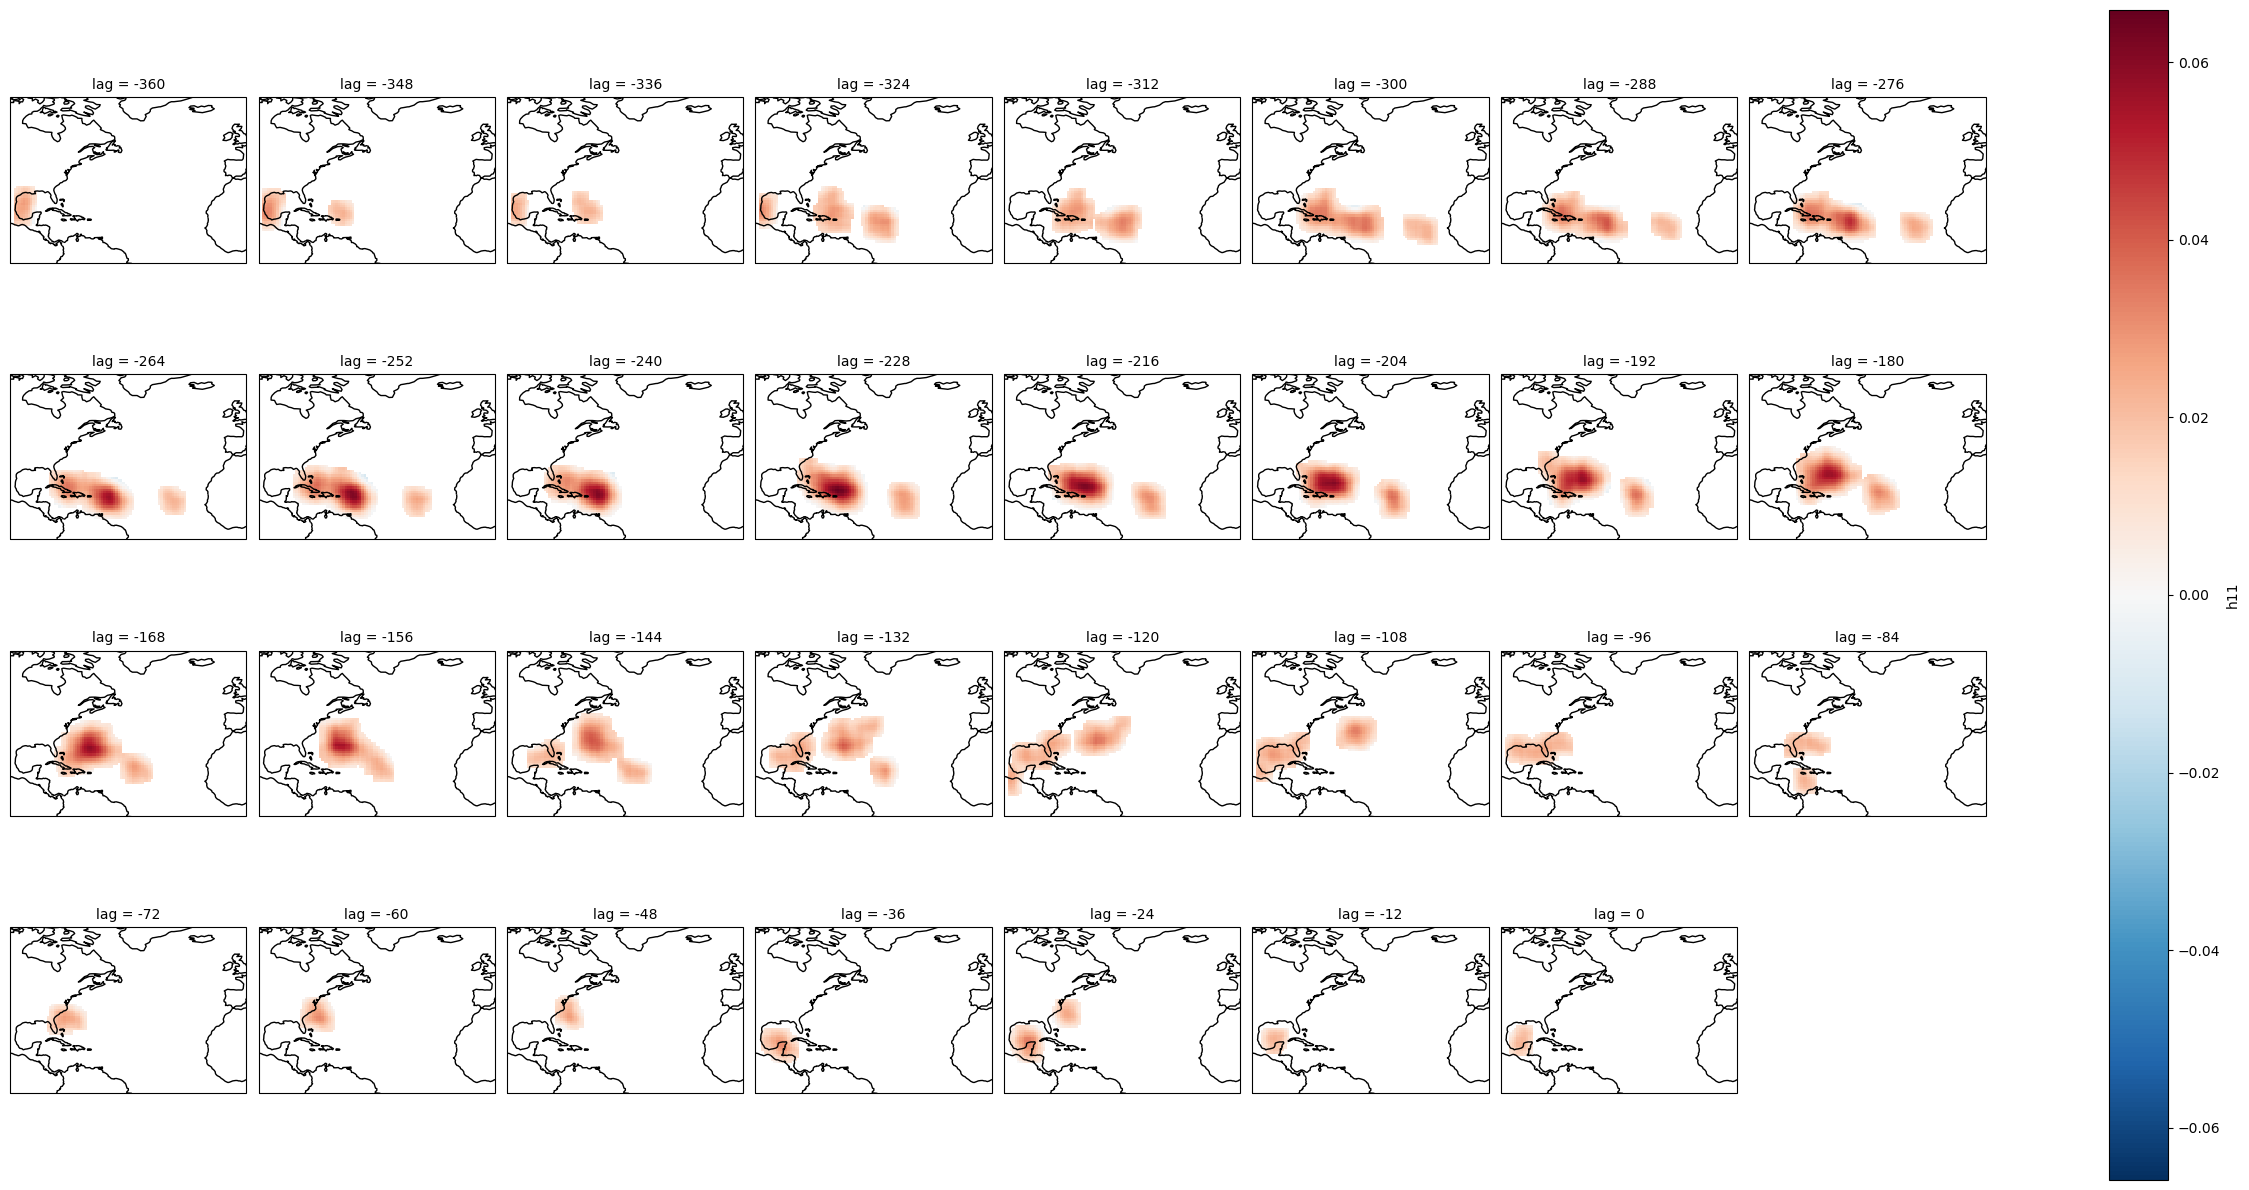

In [237]:
analyser=LaggedAnalyser(event=events,variables=dict(h11=hurricanes_10deg))
analyser.lag_variables(np.arange(-360,1,12),offset_unit='hours')
C=analyser.compute_composites(as_anomaly=True)
Cfull=analyser.compute_composites(as_anomaly=False)
S=analyser.bootstrap_significance(400,p=0.05,reuse_lag0_boots=False,synth_mode='shuffle')
Csmooth=C.rolling(lat=5,center=True).mean().rolling(lon=5,center=True).mean()
maskfilter=PatternFilter(val_ds=Csmooth,mask_ds=S)
maskfilter.apply_value_mask(anom_C_geq_thresh,0.02)
maskfilter.apply_convolution(7,('lat','lon'))
maskfilter.apply_area_mask(100,dims=('lat','lon'),area_type='spherical')
M=maskfilter.get_mask()
CM=Csmooth.where(M==1)
p=CM.h11.sel(index_val=1).plot(col='lag',col_wrap=8,transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.PlateCarree()))
for a in p.axes.flat:
    a.coastlines()
    a.set_extent([-100,0,0,70],crs=ccrs.PlateCarree())

In [238]:
slices=[dict(index_val=1,lag=l) for l in np.arange(-360,1,24)]
SON_hurricanes=hurricanes[hurricanes['time.season']=='SON'].to_dataset(name='h11')
IG=IndexGenerator()
indices=IG.generate(CM,SON_hurricanes,slices=slices)
index_analyser=LaggedAnalyser(event=events,variables=indices)
index_analyser.lag_variables(np.arange(-20,1))
Cfull=index_analyser.compute_composites(as_anomaly=False)
Canom=index_analyser.compute_composites(as_anomaly=True)

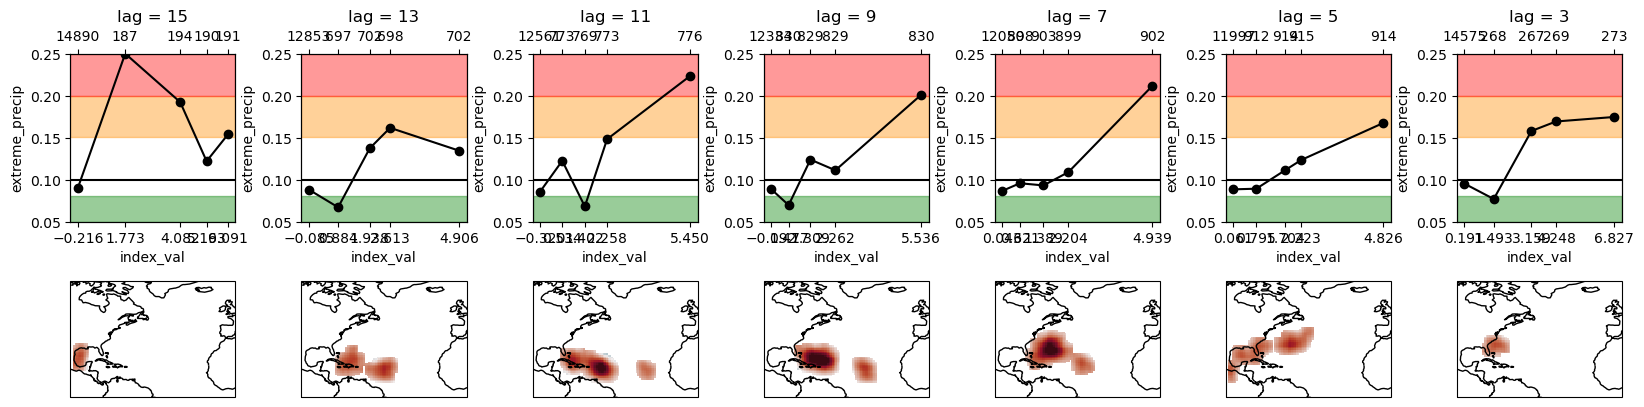

In [239]:
fig=plt.figure()
lags=np.arange(-360,1,48)
for n in range(7):
    a1=fig.add_subplot(2,8,n+1)
    a3=fig.add_subplot(2,8,n+9,projection=ccrs.PlateCarree())
    
    l=lags[n]
    ix=indices[f'h11_index_val1_lag{l}']
    #we make the index nonstandardised:
    a,b=np.unique(ix,return_counts=True)
    mode=a[np.argmax(b)]
    ix=ix-mode

    #We convert to a categorical index
    bin_boundaries=np.array([ix.min(),*ix[ix>0].quantile(np.arange(0.0,1.01,0.25)).values])
    index_categories=np.digitize(ix,bin_boundaries)
    index_categories[index_categories==index_categories.max()]=index_categories.max()-1
    index_categories=xr.DataArray(data=index_categories,coords=dict(time=ix.time))
    ixfocus_analyser=LaggedAnalyser(event=index_categories,variables=events,name='extreme_precip')
    ixfocus_analyser.lag_variables(np.arange(0,21))
    event_C=ixfocus_analyser.compute_composites(as_anomaly=False)

    bin_labels=[f'{bi:.2f}-{bf:.2f}' for bi,bf in zip(bin_boundaries[:-1],bin_boundaries[1:])]
    bin_centres=[(bi+bf)/2 for bi,bf in zip(bin_boundaries[:-1],bin_boundaries[1:])]
    event_C=event_C.assign_coords(coords={'index_val':bin_centres})
    event_C.sel(lag=-l/24).extreme_precip.plot(marker='o',ax=a1,color='k')
    a1.set_xticks(bin_centres,fontsize=8)
    a1.set_ylim(0.05,0.25)
    xlim=a1.get_xlim()
    a1.hlines(0.1,*xlim,colors='k')
    a2=a1.twiny()
    n=np.unique(index_categories,return_counts=True)[1]
    a2.set_xticks(bin_centres,fontsize=8)
    a2.set_xticklabels(n)
    a1.set_xlim(xlim)
    a2.set_xlim(xlim)
    
    a1.fill_between(xlim,0.05,0.08,color='green',alpha=0.4)
    a1.fill_between(xlim,0.151,0.2,color='darkorange',alpha=0.4)
    a1.fill_between(xlim,0.2,0.25,color='red',alpha=0.4)

    p=CM.h11.sel(index_val=1,lag=l).plot(ax=a3,transform=ccrs.PlateCarree(),vmin=-0.05,vmax=0.05,cmap=cm.balance,add_colorbar=False)
    a3.coastlines()
    a3.set_title('')
    a3.set_extent([-100,0,0,70],crs=ccrs.PlateCarree())
fig.set_figwidth(23)
fig.subplots_adjust(wspace=0.4)



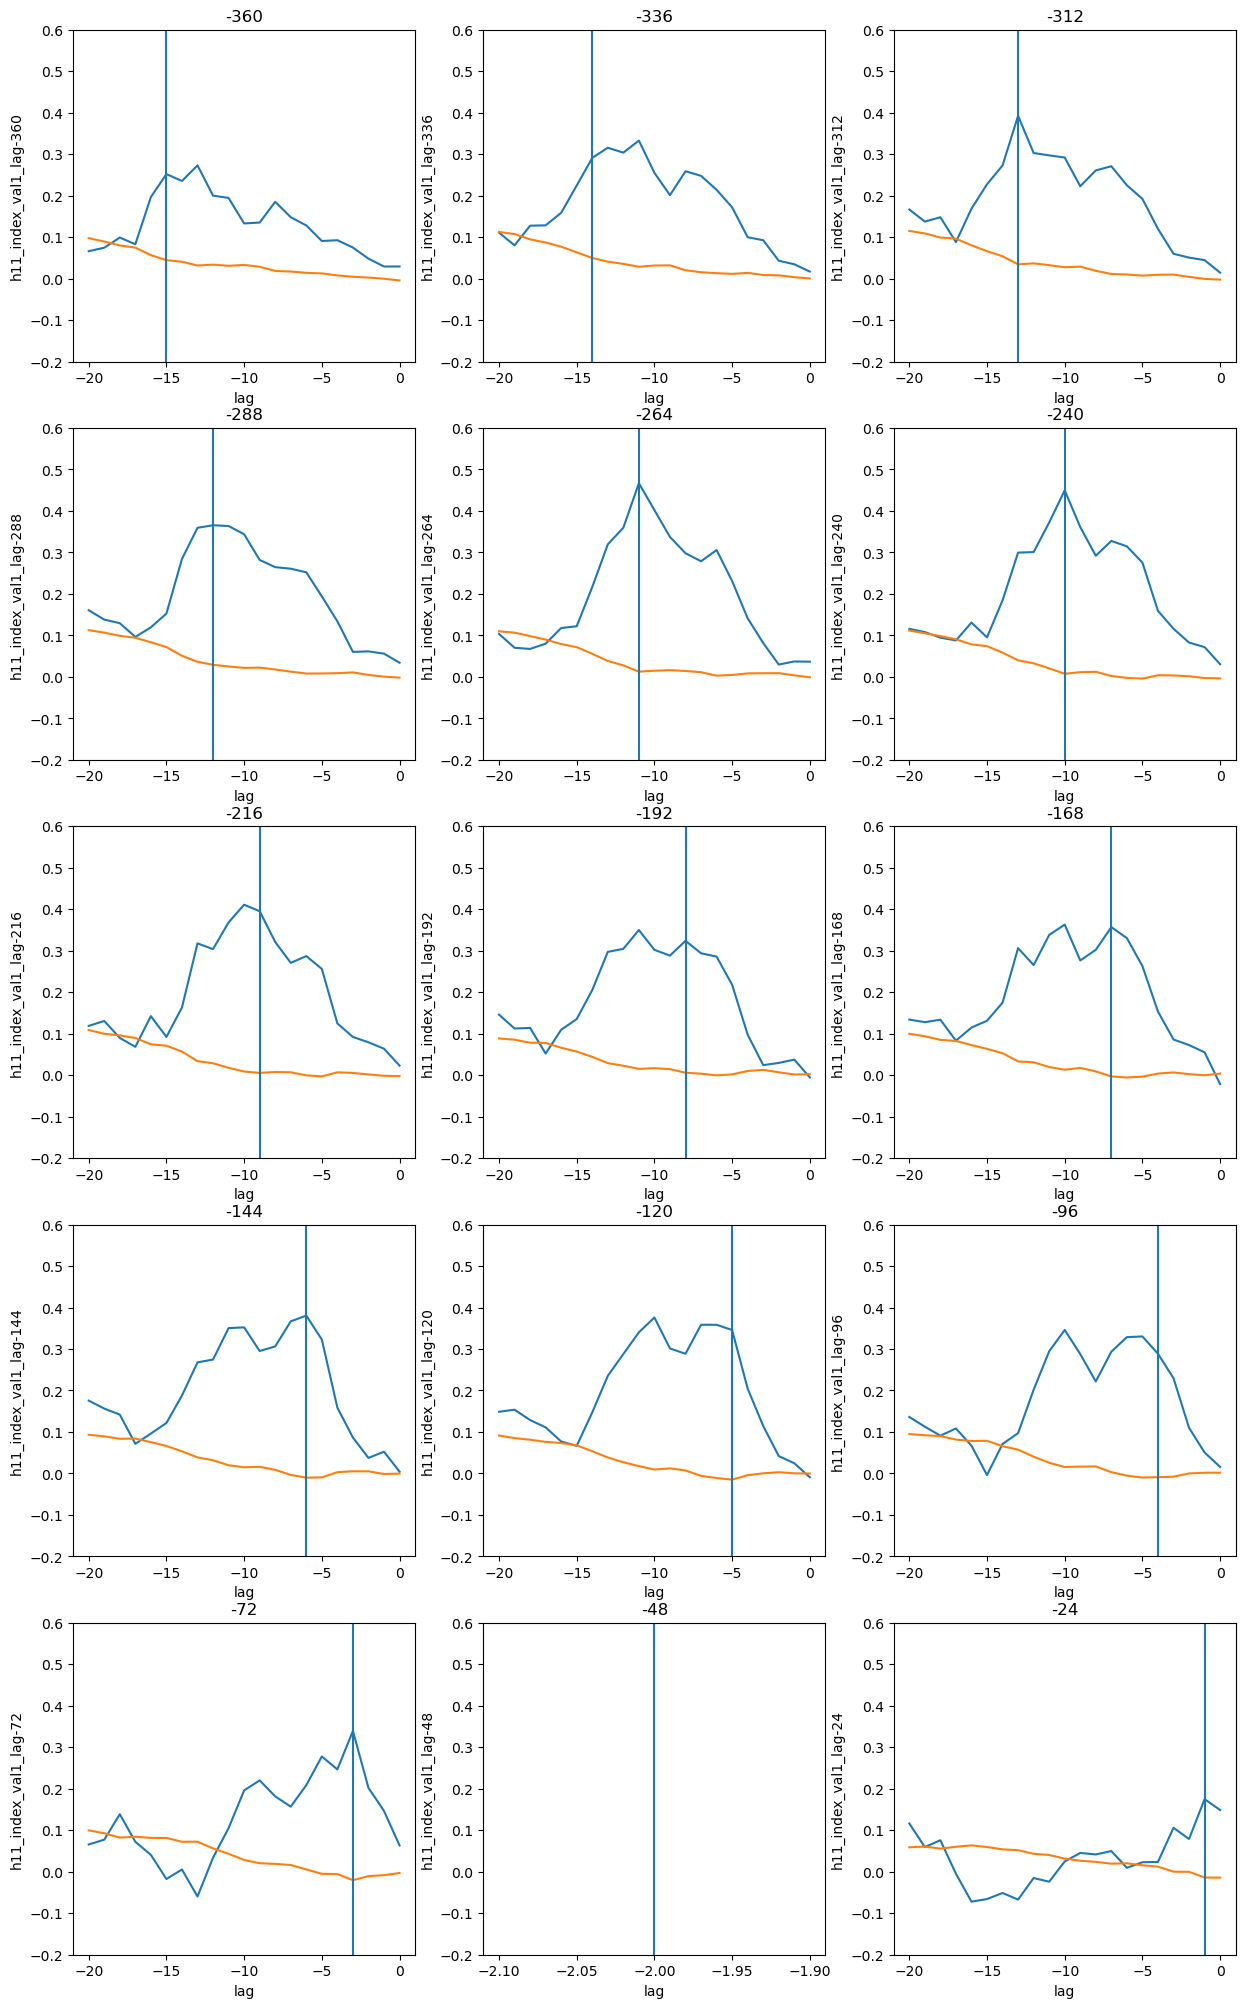

In [56]:
fig,ax=plt.subplots(5,3)
for l,a in zip(range(-360,1,24),ax.flat):
    
    Cfull.sel(index_val=1)[f'h11_index_val1_lag{l}'].plot(ax=a)
    Cfull.sel(index_val=0)[f'h11_index_val1_lag{l}'].plot(ax=a)
    a.set_title(l)
    a.set_ylim(-0.2,0.6)
    a.vlines(l/24,-0.2,0.6)
fig.set_figwidth(15)
fig.set_figheight(25)

# Break

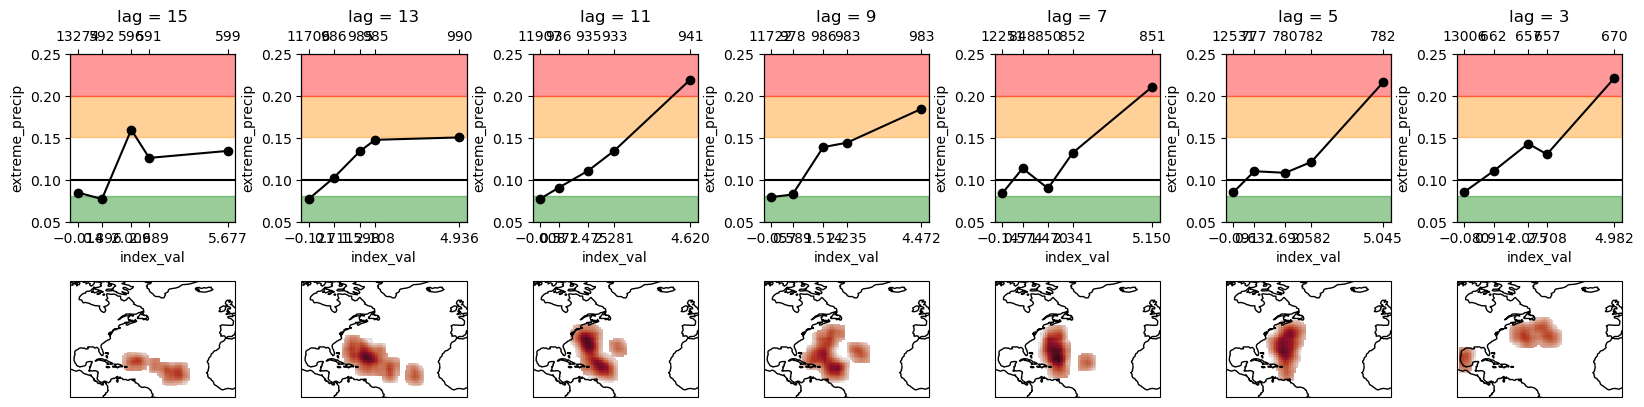

In [229]:
fig=plt.figure()
lags=np.arange(-360,1,48)
for n in range(7):
    a1=fig.add_subplot(2,8,n+1)
    a3=fig.add_subplot(2,8,n+9,projection=ccrs.PlateCarree())
    
    l=lags[n]
    ix=indices[f'h11_index_val1_lag{l}']
    #we make the index nonstandardised:
    a,b=np.unique(ix,return_counts=True)
    mode=a[np.argmax(b)]
    ix=ix-mode

    #We convert to a categorical index
    bin_boundaries=np.array([ix.min(),*ix[ix>0].quantile(np.arange(0.0,1.01,0.25)).values])
    index_categories=np.digitize(ix,bin_boundaries)
    index_categories[index_categories==index_categories.max()]=index_categories.max()-1
    index_categories=xr.DataArray(data=index_categories,coords=dict(time=ix.time))
    ixfocus_analyser=LaggedAnalyser(event=index_categories,variables=events,name='extreme_precip')
    ixfocus_analyser.lag_variables(np.arange(0,21))
    event_C=ixfocus_analyser.compute_composites(as_anomaly=False)

    bin_labels=[f'{bi:.2f}-{bf:.2f}' for bi,bf in zip(bin_boundaries[:-1],bin_boundaries[1:])]
    bin_centres=[(bi+bf)/2 for bi,bf in zip(bin_boundaries[:-1],bin_boundaries[1:])]
    event_C=event_C.assign_coords(coords={'index_val':bin_centres})
    event_C.sel(lag=-l/24).extreme_precip.plot(marker='o',ax=a1,color='k')
    a1.set_xticks(bin_centres,fontsize=8)
    a1.set_ylim(0.05,0.25)
    xlim=a1.get_xlim()
    a1.hlines(0.1,*xlim,colors='k')
    a2=a1.twiny()
    n=np.unique(index_categories,return_counts=True)[1]
    a2.set_xticks(bin_centres,fontsize=8)
    a2.set_xticklabels(n)
    a1.set_xlim(xlim)
    a2.set_xlim(xlim)
    
    a1.fill_between(xlim,0.05,0.08,color='green',alpha=0.4)
    a1.fill_between(xlim,0.151,0.2,color='darkorange',alpha=0.4)
    a1.fill_between(xlim,0.2,0.25,color='red',alpha=0.4)

    p=CM.h11.sel(index_val=1,lag=l).plot(ax=a3,transform=ccrs.PlateCarree(),vmin=-0.05,vmax=0.05,cmap=cm.balance,add_colorbar=False)
    a3.coastlines()
    a3.set_title('')
    a3.set_extent([-100,0,0,70],crs=ccrs.PlateCarree())
fig.set_figwidth(23)
fig.subplots_adjust(wspace=0.4)

In [91]:
event_S=ixfocus_analyser.bootstrap_significance(400,p=0.05,synth_mode='markov',reuse_lag0_boots=False)

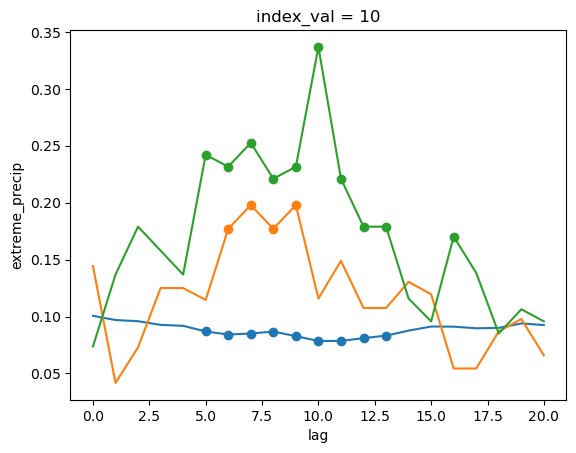

In [96]:
event_C.sel(index_val=0).extreme_precip.plot(marker='o',markevery=(event_S.sel(index_val=0)==1).extreme_precip.values)
event_C.sel(index_val=9).extreme_precip.plot(marker='o',markevery=(event_S.sel(index_val=9)==1).extreme_precip.values)
event_C.sel(index_val=10).extreme_precip.plot(marker='o',markevery=(event_S.sel(index_val=10)==1).extreme_precip.values)

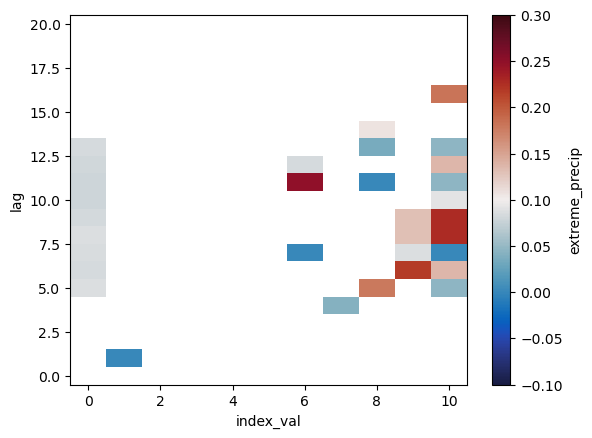

In [119]:
import cmocean.cm as cm
event_C.where(event_S==1).extreme_precip.plot(vmin=-0.1,vmax=0.3,cmap=cm.balance)

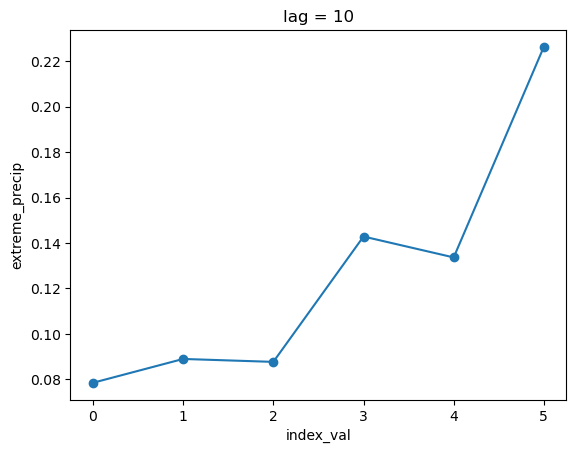

In [75]:
lags=np.arange(48,241,24)
Cs=[]
Ss=[]
for l in lags:
    
    quantiles=Cindex[f'hurricane_index_val1_lag-{l}'].quantile(np.linspace(0,1,21))

    index_categories=np.digitize(Cindex[f'hurricane_index_val1_lag-{l}'],quantiles)
    index_categories[index_categories==21]=20
    index_categories=xr.DataArray(data=index_categories,coords=dict(time=Cindex.time),dims=['time'])
    event_analyser=LaggedAnalyser(event=index_categories,variables=events,name='extreme_rain')
    event_analyser.lag_variables(range(-60,361,6),offset_unit='hours')
    index_C=event_analyser.compute_composites(as_anomaly=False)
    index_S=event_analyser.bootstrap_significance(400,0.05,synth_mode='shuffle')
    Cs.append(index_C)
    Ss.append(index_S)

NameError: name 'Cindex' is not defined

In [152]:
C_da=xr.concat(Cs,'precursor_lags')
S_da=xr.concat(Ss,'precursor_lags')

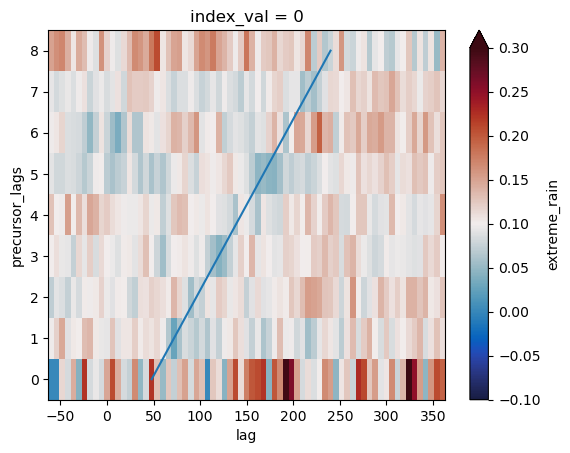

In [172]:
import cmocean.cm as cm
import matplotlib.pyplot as plt
C_da.sel(index_val=0).extreme_rain.plot(vmin=-0.1,vmax=0.3,cmap=cm.balance)
plt.plot(lags,range(9))

In [98]:
Msc_analyser=LaggedAnalyser(event=events,variables=Mindex)
Msc_analyser.lag_variables(np.arange(-360,1,6),offset_unit='hours')
M_scC=Msc_analyser.compute_composites()
M_scS=Msc_analyser.bootstrap_significance(bootnum=400,p=0.05,synth_mode='shuffle')

In [99]:
Csc_analyser=LaggedAnalyser(event=events,variables=Cindex)
Csc_analyser.lag_variables(np.arange(-360,1,6),offset_unit='hours')
C_scC=Csc_analyser.compute_composites()
C_scS=Csc_analyser.bootstrap_significance(bootnum=400,p=0.05,synth_mode='shuffle')

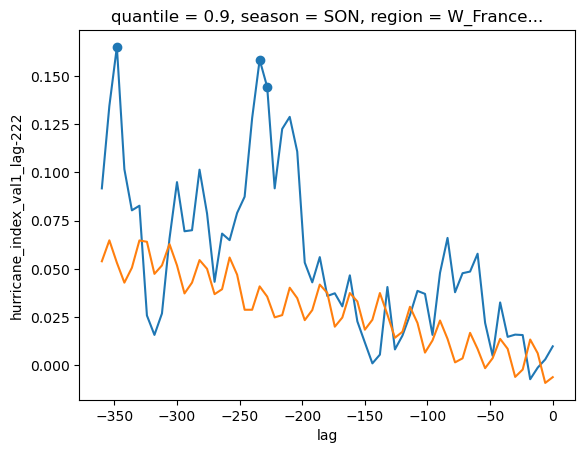

In [101]:
M_scC.sel(index_val=1)['hurricane_index_val1_lag-222'].plot(marker='o',
    markevery=M_scS.sel(index_val=1)['hurricane_index_val1_lag-222']==1)
M_scC.sel(index_val=0)['hurricane_index_val1_lag-222'].plot()

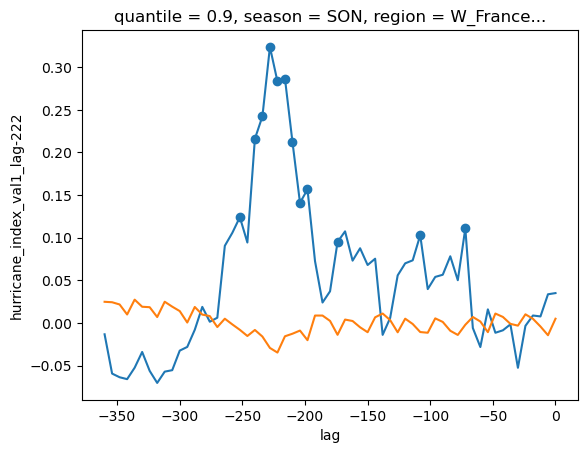

In [100]:
C_scC.sel(index_val=1)['hurricane_index_val1_lag-222'].plot(marker='o',
    markevery=C_scS.sel(index_val=1)['hurricane_index_val1_lag-222']==1)
C_scC.sel(index_val=0)['hurricane_index_val1_lag-222'].plot()

In [118]:
Cs=[]
Ss=[]
for l in lags:
    quantiles=Cindex[f'hurricane_index_val1_lag-{l}'].quantile(np.linspace(0,1,21))

    index_categories=np.digitize(Cindex['hurricane_index_val1_lag-{l}'],quantiles)
    index_categories[index_categories==21]=20
    index_categories=xr.DataArray(data=index_categories,coords=dict(time=Cindex.time),dims=['time'])
    event_analyser=LaggedAnalyser(event=index_categories,variables=events,name='extreme_rain')
    event_analyser.lag_variables(range(-60,361,6),offset_unit='hours')
    index_C=event_analyser.compute_composites(as_anomaly=False)
    index_S=event_analyser.bootstrap_significance(400,0.05,synth_mode='shuffle')
    Cs.append(index_C)
    Ss.append(index_S)

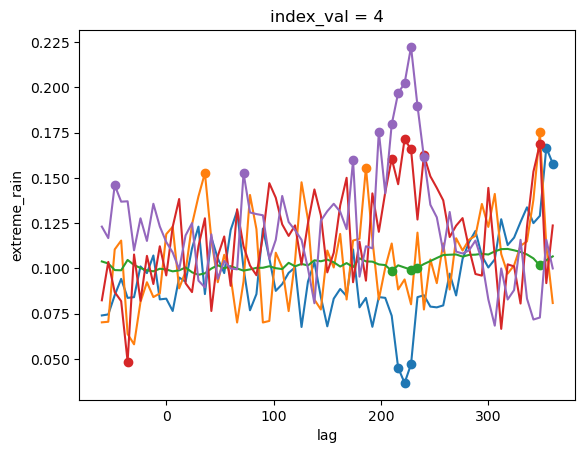

In [143]:
index_C.sel(index_val=0).extreme_rain.plot(marker='o',markevery=index_S.extreme_rain.sel(index_val=0)==1)
index_C.sel(index_val=1).extreme_rain.plot(marker='o',markevery=index_S.extreme_rain.sel(index_val=1)==1)
index_C.sel(index_val=2).extreme_rain.plot(marker='o',markevery=index_S.extreme_rain.sel(index_val=2)==1)
index_C.sel(index_val=3).extreme_rain.plot(marker='o',markevery=index_S.extreme_rain.sel(index_val=3)==1)
index_C.sel(index_val=4).extreme_rain.plot(marker='o',markevery=index_S.extreme_rain.sel(index_val=4)==1)

In [73]:
sc_analyser=LaggedAnalyser(event=events,variables=Mindex)
sc_analyser.lag_variables(np.arange(-360,1,6),offset_unit='hours')
C=sc_analyser.compute_composites()

In [76]:
S=sc_analyser.bootstrap_significance(bootnum=400,p=0.05,synth_mode='shuffle')

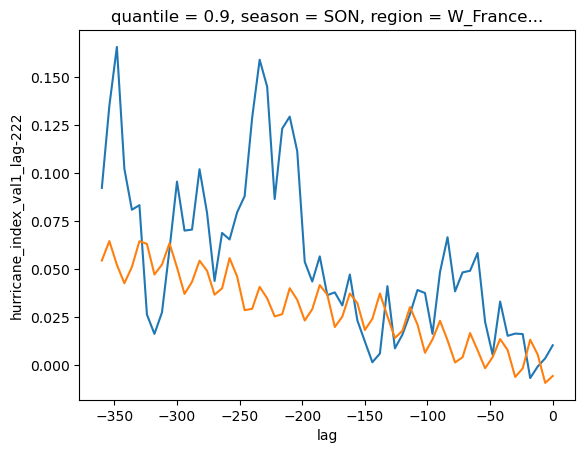

In [77]:
C.sel(index_val=1)['hurricane_index_val1_lag-222'].plot(marker='o',
    markevery=S.sel(index_val=1)['hurricane_index_val1_lag-222']==1)
C.sel(index_val=0)['hurricane_index_val1_lag-222'].plot()

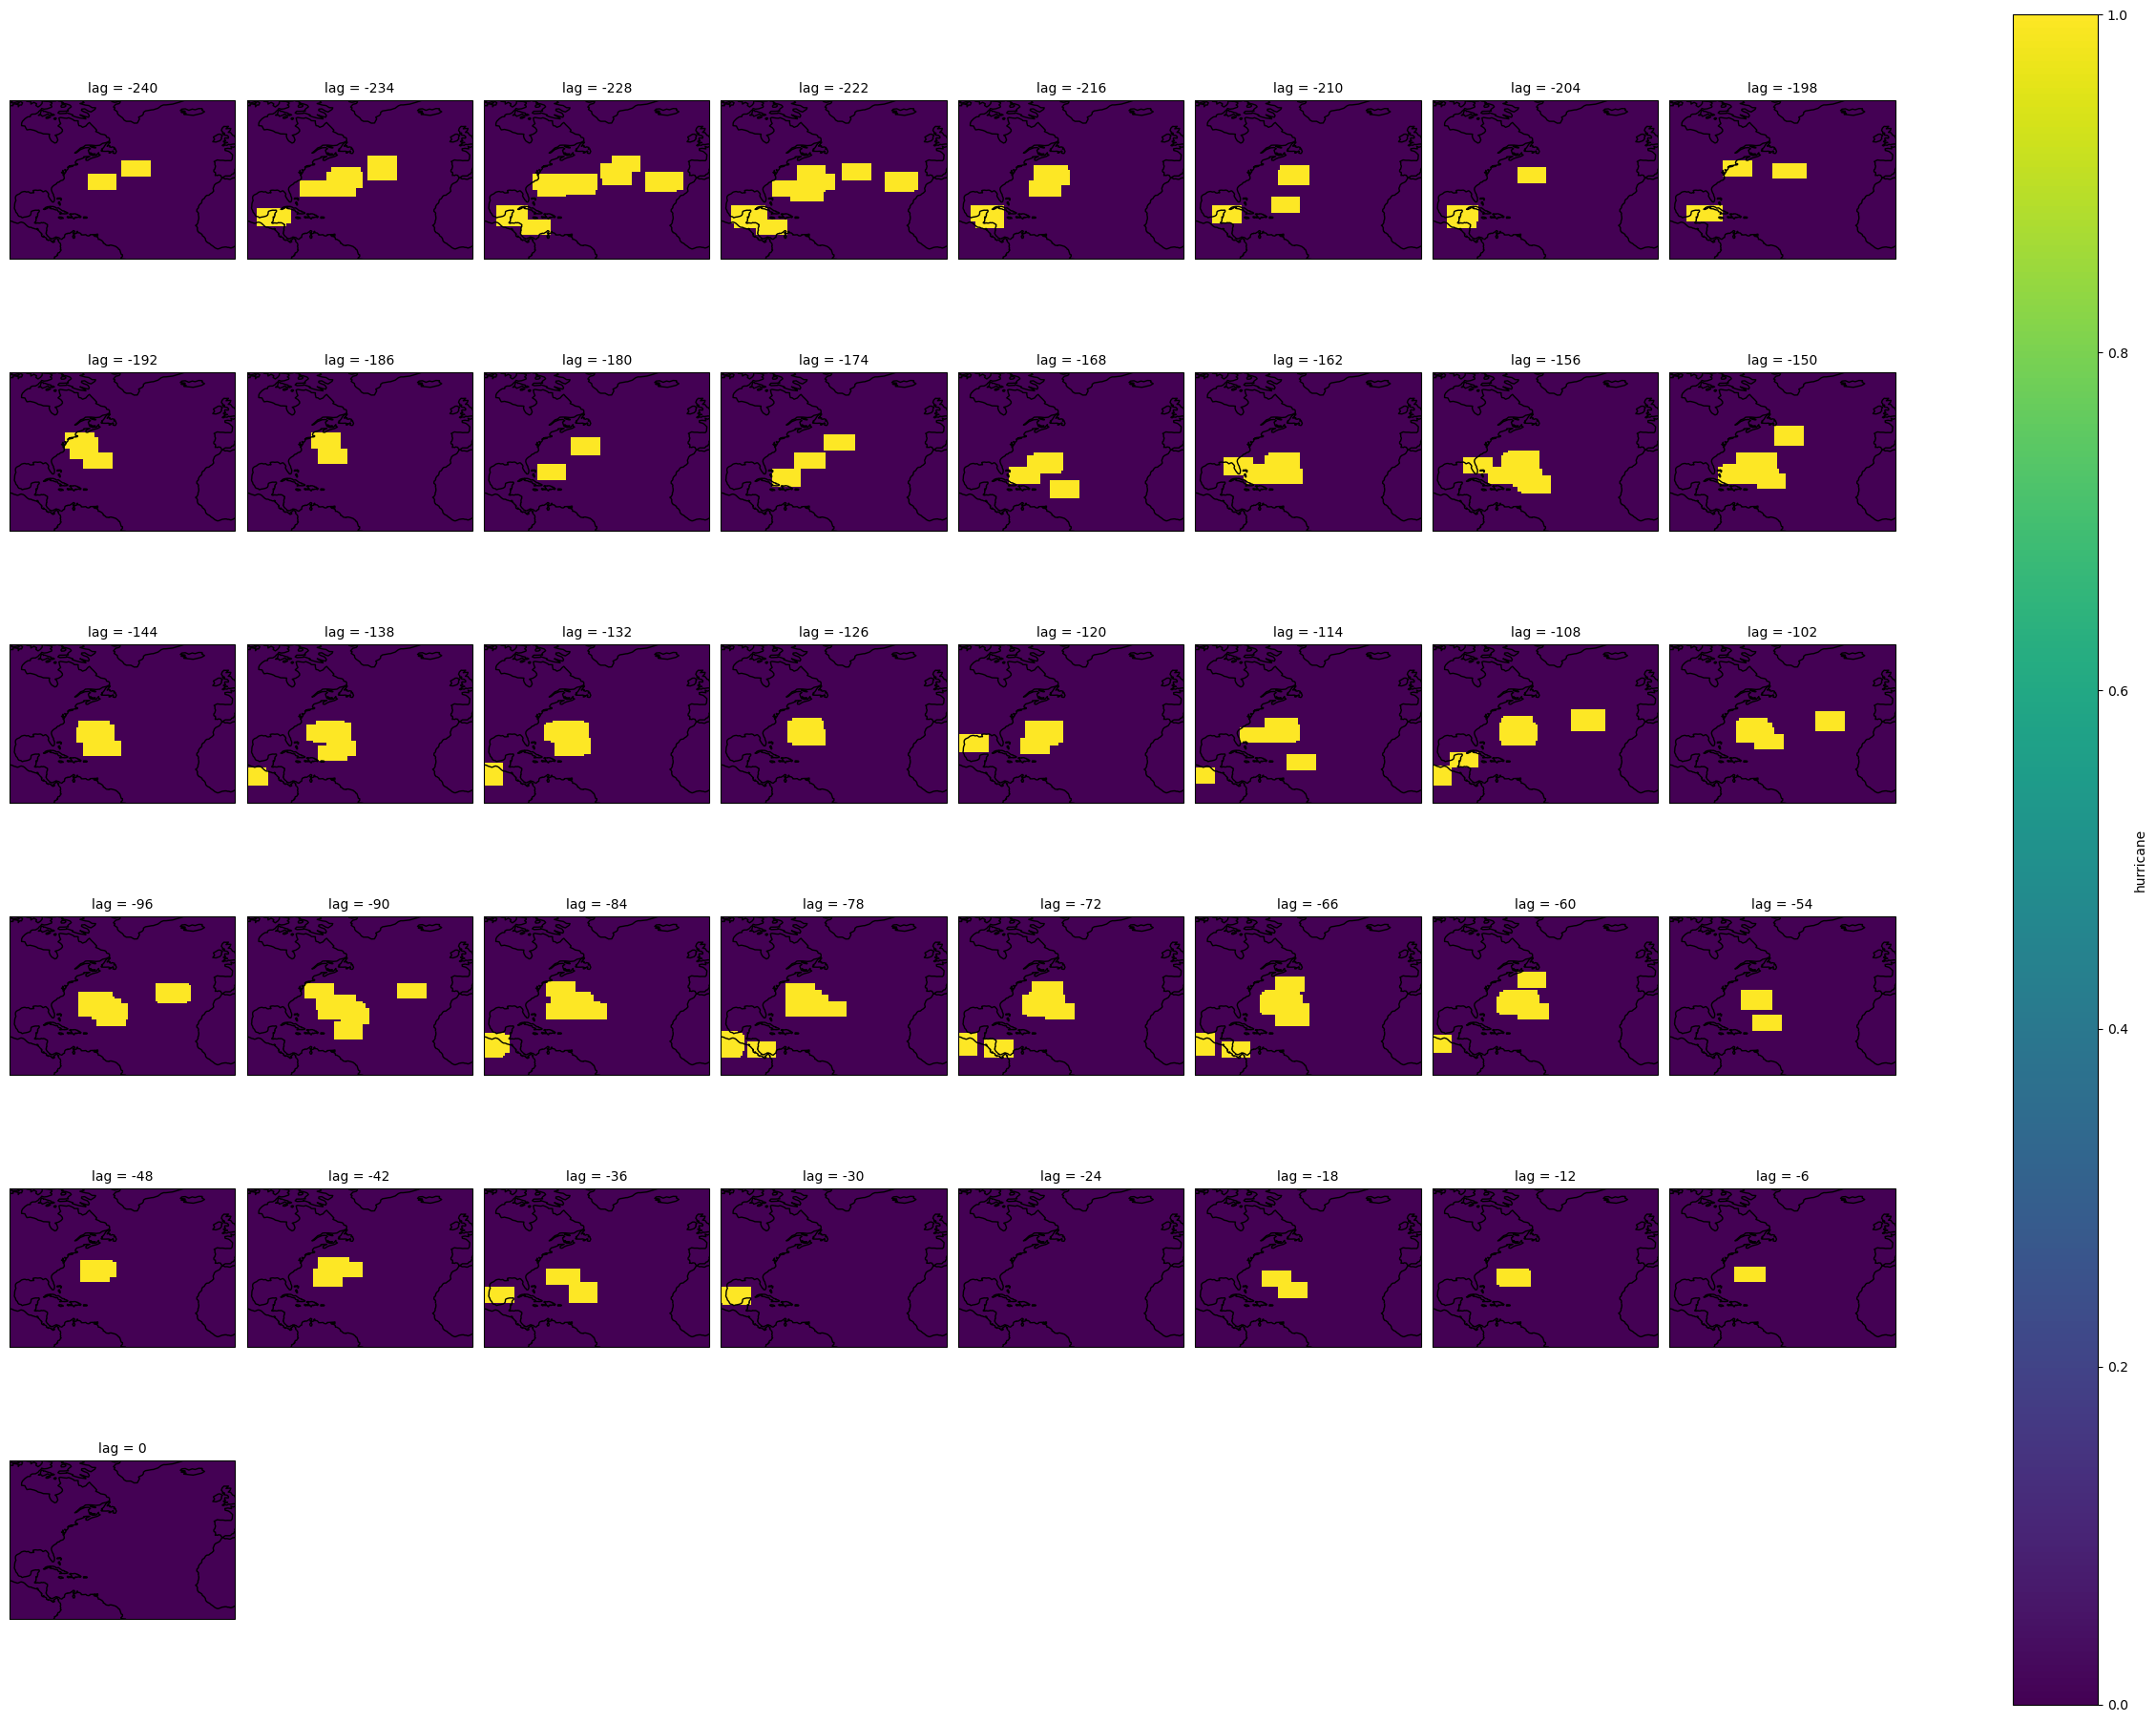

In [105]:
p=M.hurricane.sel(index_val=1).plot(col='lag',col_wrap=8,transform=ccrs.PlateCarree(),subplot_kws=dict(projection=ccrs.PlateCarree()))
for a in p.axes.flat:
    a.coastlines()
    a.set_extent([-100,0,0,70],crs=ccrs.PlateCarree())

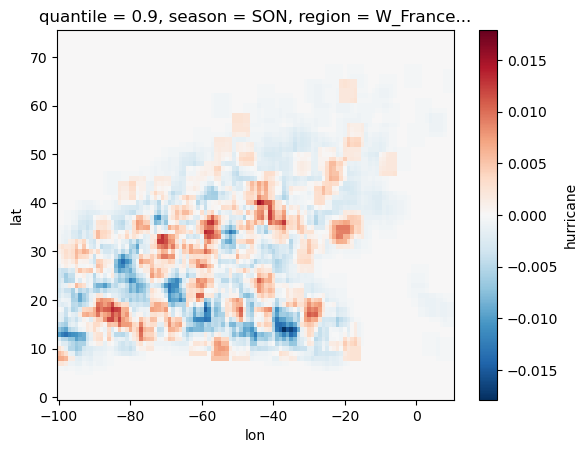

In [82]:
(C.sel(index_val=1)-C.sel(index_val=0)).sel(lag=-240).hurricane.plot()